In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=PendingDeprecationWarning)
warnings.filterwarnings(action='ignore', category=ResourceWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

In [3]:
import pandas as pd
import numpy as np
import os
import pickle

In [10]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
# gensim
import gensim 
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [12]:
import gensim
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def extract_text(text_path):
    with open(text_path, 'r') as content_file:
        text = content_file.read()
    return text

In [15]:
class TextVectorWrap:
    
    CLEAN_DOUBLECHECK_STOPS = ['chapter','chap','appendix','volume','introduction','page','vol','ibid','vol','www','http','com','htm',
                            'ourhollowearth','excerpt', 'htm','matrix iii','see also','turner','index','idaho observer','acknowledgments',
                            'also','issn exopoliticsjournal','exopolitics journal','choice echo','ing','matrix volume','publichealthlaw','publichealthlaw net'
                            'ats member','member comment','web archive', 'archive org', 'org web', 'photograph reprinted',  'net msehpa',  'msehpa pdf', 'nrel', 
                            'reprinted nrel', 'downloading web',  'publichealthlaw', 'publichealthlaw net']
    
    def __init__(self, text_path=None, documents=None, extra_stops=[], max_df=0.6, pickle_to=None, display=True):
        
        texts = []
        filenames = []
        
        if text_path and not documents:
            # Get text filenames
            filenames = sorted([filename for filename in os.listdir(text_path) if '.txt' in filename])
            if filenames == []: print('No text files found!')
            
            # Grab texts
            for filename in filenames:
                #print(filename)
                text = extract_text(text_path+filename)
                texts.append(text)
        elif documents and not text_path:
            texts = documents
        else:
            raise IOException('You need to pass a text file path or a list of documents')
        
        # Modify stopwords
        stop_words = set(stopwords.words('english'))
        stop_words.update(TextVectorWrap.CLEAN_DOUBLECHECK_STOPS)
        stop_words.update(extra_stops)
    
        # Vectorize
        if display: print('vectorizing: max_df='+str(max_df)+' num_extra_stops='+str(len(extra_stops))+' corpus size ='+str(len(texts)))
        vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                     stop_words=stop_words, 
                                     token_pattern="\\b[a-z][a-z][a-z]+\\b",
                                     lowercase=True,
                                     max_df = max_df)
        vector = vectorizer.fit_transform(texts)

        # Define self
        self.filenames = filenames
        self.extra_stops = extra_stops
        self.vectorizer = vectorizer
        self.vector = vector
        self.max_df = max_df
        self.pickle_to = pickle_to
        
        # Pickle
        try:
            if pickle_to:
                pickle.dump(self,open(pickle_to,'wb'))
        except:
            print('pickling failed')

In [16]:
class LdaWrap:
    def __init__(self, vectorwrap_file, pickle_to=None, n_topics=20, min_prob=0.03, passes=10, display=True):
        
        # Load up vector
        if display: print('loading vector')
        vectorwrap = pickle.load(open(vectorwrap_file,'rb'))
        vector = vectorwrap.vector
        vectorizer = vectorwrap.vectorizer
        filenames = vectorwrap.filenames
        vector_T = vector.transpose()
        n_texts = vector.shape[0]
        
        # Build corpus
        if display: print('building corpus')
        corpus = matutils.Sparse2Corpus(vector_T)

        # ID to word dict
        if display: print('defining id2word')
        id2word = { identifier: word for word, identifier in vectorizer.vocabulary_.items()}

        # LDA
        if display: print('lda modeling on corpus len='+str(len(corpus)))
        lda = models.LdaModel(corpus=corpus, num_topics=n_topics, minimum_probability=min_prob, 
                                      id2word=id2word, passes=passes)
        
        # Lists of words describing topics
        if display: print('building topic terms')
        terms = []
        for topic_i in range(n_topics):
            terms.append([id2word[term[0]] for term in lda.get_topic_terms(topic_i)])
            
        # Create topic probs for each text
        if display: print('generating text topic probs')
        texts_topics=np.zeros((n_texts,n_topics))
        for text_i, text in enumerate(corpus):
            text_topics = lda.get_document_topics(text)
            for topic, prob in text_topics:
                texts_topics[text_i, topic] = prob   
           
        # Define self
        if display: print('assigning data')
        self.vectorwrap_file = vectorwrap_file
        self.filenames = filenames
        self.max_df = vectorwrap.max_df
        self.n_texts = n_texts
        self.corpus = corpus
        self.id2word = id2word
        
        self.n_topics = n_topics
        self.min_prob = min_prob
        self.passes = passes  
        self.lda = lda
        self.terms = terms
        self.texts_topics = texts_topics
        self.perplexity = lda.log_perplexity(corpus)
        
        self.pickle_to = pickle_to
        
        # Pickle
        try:
            if pickle_to:
                if display: print('pickling')
                #pickle.dump(self,open(pickle_to,'wb'))
                pickle.dump(self,open(pickle_to,'wb'))
        except:
            print('pickling failed')
            
    def get_top_terms(self):
        result = []
        
        tops = self.lda.top_topics(self.corpus)
        topics = [(topic, score) for topic, score in tops]
        topics_terms = [term for term, _ in topics]
        scores = [score for _,score in tops]
        for topic in topics_terms:
            clean_topic = [term for _,term in topic]
            result.append(clean_topic)
        return list(zip(scores,result))
    
    def make_doc_topics(self, corpus):
        if display: print('generating text topic probs')
        texts_topics=np.zeros((len(corpus),self.n_topics))
        for text_i, text in enumerate(corpus):
            text_topics = self.lda.get_document_topics(text)
            for topic, prob in text_topics:
                texts_topics[text_i, topic] = prob
        return texts_topics

In [17]:
"""
# Rebuild final model
n_topics = 25
max_df = 0.8
TextVectorWrap('Clean/', extra_stops=[], max_df=max_df, pickle_to='final_vectorwrap.pkl')

min_prob=0.03
passes=10
ldawrap = LdaWrap('final_vectorwrap.pkl', pickle_to='final_ldawrap.pkl', n_topics=n_topics, min_prob=min_prob, passes=passes, display=True)

vectorizing: max_df=0.8 num_extra_stops=0 corpus size =175


KeyboardInterrupt: 

In [18]:
lda_wrap = pickle.load(open('final_ldawrap.pkl','rb'))

In [19]:
def summarize_text(text, n_summary_sent=1):
    """
    Return a list of n_sentences with greatest similarity to overall text.
    """
    
    # Tokenize sentences
    sentences = sent_tokenize(text)
    
    # Vectorize sentences
    cv = CountVectorizer(stop_words="english")
    X = cv.fit_transform(sentences).toarray()
    
    # Make similarities
    X_sparse = sparse.csr_matrix(X)
    similarities = cosine_similarity(X_sparse)
    similarities_sparse = cosine_similarity(X_sparse,dense_output=False)
    sent_similarities = sorted(zip(np.mean(similarities,axis=1),sentences), reverse=True)
    
    return [sentence[1] for sentence in sent_similarities][:n_summary_sent]

In [20]:
def summarize_file(text_path, text_char_limit=None, n_summary_sent=1):
    text = extract_text(text_path)
    if text_char_limit:
        text = text[:text_char_limit]
    return summarize_text(text,n_summary_sent=n_summary_sent)

In [21]:
texts_topics = lda_wrap.texts_topics
texts_topics.shape

(175, 25)

In [22]:
topics = ['Anti-Government',
          '?1',
          'Christianity/Antichrist',
          '?3',
          'Mind-Control',
          'New_Age',
          'NWO',
          'Noosphere',
          'Illuminati',
          'Airlines',
          'Reptilian_Masters',
          '?11',
          'Aliens/Ancient',
          '?I_AM/Mind_Control',
          'Anthrax/Biothreats',
          'Islam',
          '?16',
          '?17',
          '?18',
          'Birthers',
          '?Illuminati/Hallucinogens',
          'Holocaust',
          'Govt_Internment',
          'Pale_Horse',
          '?Obama-JFK-Catholicism']

books=[]
authors=[]
pub_dates=[]

filenames = sorted([filename for filename in lda_wrap.filenames if '.txt' in filename])
for filename in filenames:
    print
    author, book, pub_date = filename.split('__')
    authors.append(author.lower())
    books.append(book.lower())
    pub_dates.append(pub_date)

#topics = pd.DataFrame(index=books, data=texts_topics, columns=topics)
    
topics_df = pd.DataFrame(index=filenames, data=texts_topics, columns=topics)
topics_df.sort_values('Christianity/Antichrist',ascending=False)['Christianity/Antichrist']

farah__Obama_Eligibility_Primer__2010.txt                              0.736226
ovason__the_secret_architecture_of_our_nations_capital__1999.txt       0.118452
keel__ufo_operation_trojan_horse__1996.txt                             0.000000
jim_keith__saucers_of_the_illuminati__1999.txt                         0.000000
jim_keith__secret_and_suppressed__1993.txt                             0.000000
jim_marrs__above_top_secret__2008.txt                                  0.000000
john_birch__blue_book__1961.txt                                        0.000000
john_birch__the-rockefeller-file__1976.txt                             0.000000
john_birch__the_politician__1960.txt                                   0.000000
john_todd__testimonial_of_witchcraft_illuminati__1973.txt              0.000000
jose_arguelles__inevitable_event__.txt                                 0.000000
Arugelles__2012_time_on_fire__2012.txt                                 0.000000
jim_keith__encyclopedia_mind_control__19

In [ ]:
topics = topics_df.columns.tolist()
for topic in topics:
    print(topic)
    
    sorted_df = topics_df.sort_values(topic,ascending=False)
    top_texts = sorted_df[sorted_df[topic]<=.5].index
    
    for top_text in top_texts:
        top_text_summary = summarize_file('Clean/'+top_text,n_summary_sent=5)
        print(top_text)
        print(top_text_summary)
        print()
    print()

Anti-Government
jose_arguelles__inevitable_event__.txt
['Time and the Technosphere: \nThe Law of Time in Human Affairs.', 'The Law of Time in Human Affairs \n\n\n\n\nTime codes and encompasses the whole of the cycle of artificial time through the \nthirteen baktun Wave Harmonic of history.', 'Time is all that the noosphere has to give us.', 'Artificial time is not the same as natural \ntime.', '0 bring \nto these children of the Earth a good Time, a Time of Peace as long, at least, as was \ntheir time of history and war, and then let that Time of Peace be multiplied sevenfold!']

jim_marrs__above_top_secret__2008.txt
['Although Marcel did not contradict the balloon explanation at the time, in\nlater years he said he was correct the first time about a craft from space\nand that he was muzzled by military authorities.', 'gest that Earth and Moon came into being far from each other, an idea that stumbles\nover the inability of astrophysicists to explain how exactly the Moon became a satel

keel__ufo_operation_trojan_horse__1996.txt
['Time lapses and inexplicable periods of total amnesia are a\nkey aspect in the UFO phenomenon, I have now received well over 1 00\nreports in which witnesses have lost from five minutes to several hours\nimmediately after sighting an unidentified flying object.', 'The year 1 9 1 3 was just one of the recently rediscovered UFO flap\nyears, with all kinds of strange objects being reponed in the sky .', 'Fewer than two percent of the known UFO sightings are reported to\nthe Air Force at all .', 'These elements include terrestrials\xad\npeople just like you and me-who are in some way connected with the\nUFO phenomenon.', 'Ironically, the UFO organizations have, themselves, suppressed and\ncensored more UFO reports than the Air Force .']

irinn__secrets_armageddon__2008.txt
['[...]\nIRINN, May 19, 2008\nIranian historian Mohammad-Taqi Taqipour: As soon as news about the Balfour Declaration reached the leaders of the Iranian Jews, they held confer

lytton__the_coming_race__2006.txt
['And since, as I shall have occasion to observe later, the intellectual conditions and social systems of this subterranean race comprise and harmonise great, and apparently antagonistic, varieties in philosophical doctrine and speculation which have from time to time been started, discussed, dismissed, and have re-appeared amongst thinkers or dreamers in the upper world,—so I may perhaps appropriately conclude this reference to the belief of the Vril-ya, that self-conscious or sentient life once given is indestructible among inferior creatures as well as in man, by an eloquent passage from the work of that eminent zoologist, Louis Agassiz, which I have only just met with, many years after I had committed to paper these recollections of the life of the Vril-ya which I now reduce into something like arrangement and form: “The relations which individual animals bear to one another are of such a character that they ought long ago to have been considered a

douglass__jfk_unspeakable__2010.txt
['Kennedy."', 'said John Kennedy.', 'Kennedy said, "I do know that.', '"You mean President Kennedy?"', 'Castro had seen Kennedy change as president: "I have an impression of \nKennedy and of Kennedy\'s character, but I formed it over the years that he \nwas President from different gestures, different attitudes.']

elsis__stand_down_911__2003.txt
['But they still dont know American Airlines Flight 11 has crashed into the WTC or that United Airlines Flight 175 has turned and has been heading straight toward New York City now for 3 minutes.', 'NORAD may have held on to the vital information of American Airlines Flight 11 for perhaps 8 minutes, maybe 10 minutes (see 8:36 a.m. statement by NORAD spokesman, Major Mike Snyder), possibly up to 26 minutes (see 8:20 a.m. American Airlines Flight 11 transponder signal stopped transmitting its IFF beacon signal) and let us not forget that the last voice transmission of American Airlines Flight 11 with Boston ai

hatton__rise_of_the_antichrist_vol_4__1998.txt
['The Jews have\n\n\n-- PJ 230 -- .', 'Jewish idealism is the destruction of Gentile society and the erection of Jewish\n\n\n-- PJ 230 -- .', 'Gentiles have suffered more from Jewish persecutions than have the Jews,\nfor after the persecutions were over, the Gentile was as much in the dark as ever; whereas Judaism\nsimply took up again its century-long march toward a goal in which it implicitly believes, and\nwhich, some say who have deep knowledge of Jewish roots in the world and who too may be\n\n\n-- PJ 230 -- .', '), destined to figure in history\nas the overshadowing result of the World War, was largely the outcome of Jewish\nthinking, of Jewish discontent, of Jewish effort to reconstruct....\n"What Jewish idealism and Jewish discontent have so powerfully contributed to\naccomplish in Russia, the same historic qualities of the Jewish mind and heart are\ntending to promote in other countries....\n"Shall America, like the Russia of the 

bramley__Gods_of_Eden_Bramley__1989.txt
['History\nindicates that the Brotherhood was turned under its new Custodial "gods" into a chilling weapon of spiritual repression\nand betrayal, despite the efforts of many sincere humanitarians to bring about true spiritual reform through Brotherhood\nchannels all the way up until today.', 'The people of ancient Mesopotamia thoroughly\nunderstood this critical fact when they mentioned a spiritual\nbeing in connection with the creation of Homo sapiens:\n\nTHE GODS OF EDEN\n4\n3\nYou have slaughtered a god together\nwith his personality [spiritual being] I\nhave removed your heavy work, I\nhave imposed your toil on man.5\nCustodial rulers knew that they needed to keep spiritual\nbeings permanently attached to human bodies in order to\nanimate those bodies and make them intelligent enough to\nperform their labors:\nIn the clay god [a spiritual entity] and Man\n[physical body of Homo sapiens] shall be bound,\nto a unity brought together;\nSo that t

texe_marrs__Beast_666_Project_LUCID__1996.txt
['card\nPROJECT L.U.C.I.D.', 'Combined with the Universal Biometrics Card and the global system of human control\nunder Project L.U.C.I.D.., ISO 9000 provides the coming World Government with a means of\ncomprehensive control.', 'Card A CIA Project ?', 'card system did not\nPROJECT L.U.C.I.D.', 'card issuing\nPROJECT L.U.C.I.D.']

texe_marrs__Days_of_Hunger_Days_of_Chaos__1999.txt
['No seed, no food—unless—you buy more seed.”\n\nNew World Order Creates “Bioserfdom”\nJeff Baker, author of Cheque Mate: The Game of Princes, a book exposing the global conspiracy of government and money,\nsuggests that the control of agricultural production and food supply is a fulfillment of Bible prophecy:\nThis will allow the complete control of all food-growing in the hands of a few New World Order (NWO) companies,\ncreating, as one writer put it, “bioserfdom.” Remember friends, the NWO folks believe that, “food is power,” and they\nwill “use it to change be

In [ ]:
topics = topics_df.columns.tolist()
for topic in ['Illuminati']:#topics:
    print(topic)
    
    top_texts = topics_df.sort_values(topic,ascending=False).index[:]
    for top_text in top_texts:
        top_text_summary = summarize_file('Clean/'+top_text,n_summary_sent=5)
        print(top_text)
        print(top_text_summary)
        print()
    print()

In [ ]:
summarize_file('Clean/'+'michael__extraterrestrial_friends_foes_curious__2011.txt',n_summary_sent=3)

In [ ]:
summarize_file('Clean/'+'morse__Foreign_Conspiracy_Against_the_Liberties_of_USA__1835.txt',n_summary_sent=5)

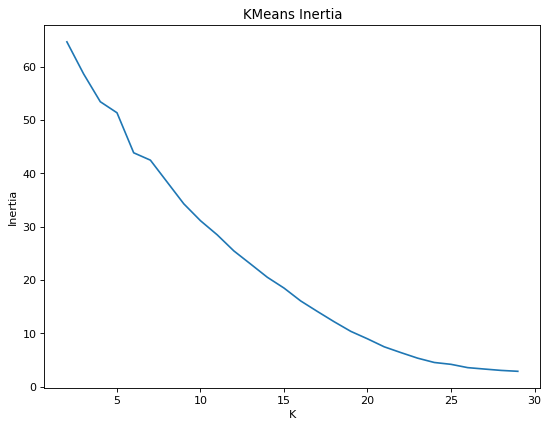

In [29]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
k_list = list(range(2,30))
km_list = []
clusters_list = []
inertia_list = []
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(texts_topics)
    clusters = km.predict(texts_topics)
    
    km_list.append(km)
    clusters_list.append(clusters)
    inertia_list.append(km.inertia_)
    
plt.plot(k_list,inertia_list)
plt.title('KMeans Inertia')
plt.xlabel('K')
plt.ylabel('Inertia');

In [26]:
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift

X = texts_topics
db = DBSCAN(eps=0.15, min_samples=3).fit_predict(X)
sc = sc = SpectralClustering(n_clusters=3)

In [27]:
db

array([-1, -1,  0, -1,  0,  1,  2,  0,  0, -1,  3, -1,  3,  4,  3,  5, -1,
        6,  7,  6, -1,  8,  9, -1,  1, 10, -1, -1,  3,  7,  3,  0,  0,  0,
        0,  8,  7,  0,  0,  3, -1, 11,  3,  6, 12,  3,  4, -1,  2, -1, 13,
        8, 12, 13,  0,  2, 12,  3,  0,  0,  0,  0, 14, -1, -1, 15, -1, 16,
       -1,  0, 16, 16, -1, -1,  9,  6, -1, 16, 14,  6, 17, 15, 14, 18, -1,
        0,  6,  3,  0,  0, 14, 18,  0,  9, -1, 17, 15,  3,  0, -1, -1, -1,
        6,  9,  0,  0, 13,  0, 13,  5,  1, 11, 11, 11, 11,  0, 13,  3, 13,
       17, 18,  0,  1,  0, 18,  0,  4, -1,  5, -1,  7, 18, 12, 18,  1, -1,
        7, 19,  4,  0, 13,  0,  9, 17, 17,  1,  7,  2,  3, 18, -1, 19,  9,
        8, 10, -1, 10,  1, -1, 19, 17, 12, 13, -1, 15,  0, -1, 11,  6,  0,
        0, 18, 12,  0,  7])

In [28]:
max(db)

19

In [ ]:
ldawrap = pickle.load(open(vectorwrap_file,'rb'))

In [14]:
def nltk_stopwords():
    return set(nltk.corpus.stopwords.words('english'))

def prep_corpus(docs, additional_stopwords=set(), no_below=5, no_above=0.5):
    print('Building dictionary...')
    dictionary = Dictionary(docs)
    stopwords = nltk_stopwords().union(additional_stopwords)
    stopword_ids = map(dictionary.token2id.get, stopwords)
    dictionary.filter_tokens(stopword_ids)
    dictionary.compactify()
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
    dictionary.compactify()

    print('Building corpus...')
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    return dictionary, corpus

In [24]:
import gensim
import gensim.corpora
import pyLDAvis.gensim
dictionary = Dictionary(lda_wrap.corpus)

NameError: name 'Dictionary' is not defined

In [ ]:
pyLDAvis.gensim.prepare(lda, corpus, dictionary)